In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry, CircularAnnulus
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.io.fits as pf
from scipy.optimize import curve_fit, leastsq
from scipy.interpolate import splrep, sproot, splev
from scipy.signal import find_peaks, peak_widths
plt.rcParams['figure.figsize'] = (15,9)

# Function to find the FWHM of our asteroid in each image

In [2]:
p1_coords = np.loadtxt('position1_coords.txt')
p2_coords = np.loadtxt('position2_coords.txt')

In [3]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fwhm(x, y):
    half_max = max(y)/2.0
    s = splrep(x, y - half_max, k=3)
    roots = sproot(s)
    return abs(roots[1] - roots[0])

def findFWHM(startimno, endimno, coords, group):     #Group = 1,2,3,4 depending on telescope position and target
    FWHMarr = []
    i = startimno
    
    if group == 1:
        
        while i <= endimno:
            myfile = pf.getdata('red_asteroid/reduced_UCD_0' + str(i) + '.fits')
            positions = coords[i-222]
        
            y = np.array(myfile[int(positions[1]), int(positions[0])-10:int(positions[0])+10])
            x = np.linspace(0,len(y),len(y))
        
            mean = sum(x * y) / sum(y)
            sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
            popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
        
            ynew = Gauss(x,*popt)
        
            FWHMarr.append(fwhm(x, ynew))
            i += 1
        return FWHMarr
    
    if group == 2:
        
        while i <= endimno:
            myfile = pf.getdata('red_asteroid/reduced_UCD_0' + str(i) + '.fits')
            positions = coords[i-285]
        
            y = np.array(myfile[int(positions[1]), int(positions[0])-10:int(positions[0])+10])
            x = np.linspace(0,len(y),len(y))
        
            mean = sum(x * y) / sum(y)
            sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
            popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
        
            ynew = Gauss(x,*popt)
        
            FWHMarr.append(fwhm(x, ynew))
            i += 1
        return FWHMarr
    
    if group == 3:
        
        while i <= endimno:
            myfile = pf.getdata('red_asteroid/reduced_UCD_0' + str(i) + '.fits')
            positions = coords[i-222]
        
            y = np.array(myfile[int(positions[1]), int(positions[0])-10:int(positions[0])+10])
            x = np.linspace(0,len(y),len(y))
        
            mean = sum(x * y) / sum(y)
            sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
            popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
        
            ynew = Gauss(x,*popt)
        
            FWHMarr.append(fwhm(x, ynew))
            i += 1
        return FWHMarr
        
    if group == 4:
        
        while i <= endimno:
            myfile = pf.getdata('red_asteroid/reduced_UCD_0' + str(i) + '.fits')
            positions = coords[i-285]
            
            y = np.array(myfile[int(positions[1]), int(positions[0])-10:int(positions[0])+10])
            x = np.linspace(0,len(y),len(y))
            
            mean = sum(x * y) / sum(y)
            sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
            popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
        
            ynew = Gauss(x,*popt)
        
            FWHMarr.append(fwhm(x, ynew))
            i += 1
        return FWHMarr
    else:
        print('Group must be 1, 2, 3 or 4')

In [4]:
p1_FWHM = findFWHM(222,284, p1_coords, 1)
p2_FWHM = findFWHM(285, 335, p2_coords, 2)

In [5]:
np.savetxt('p1_FWHM', p1_FWHM)
np.savetxt('p2_FWHM', p2_FWHM)

# Function to find the ideal aperture size to use in each image to give the highest possible SNR 

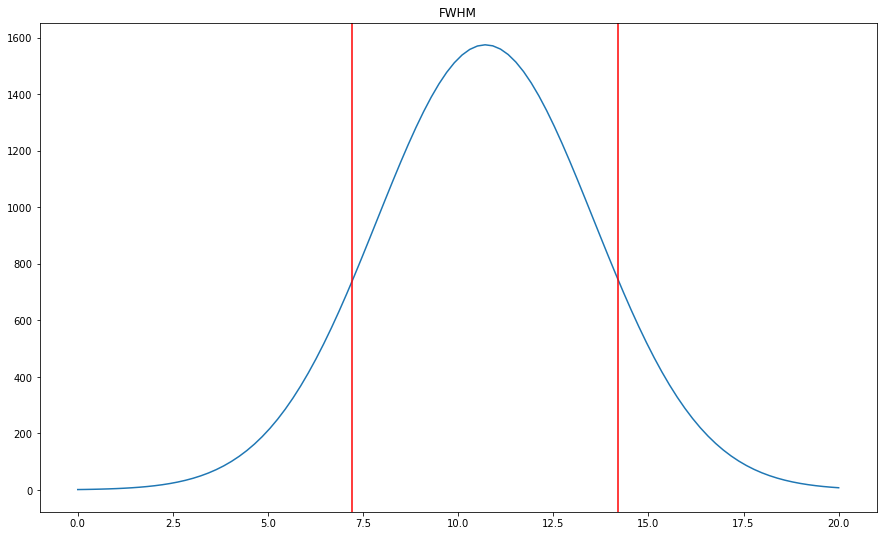

In [26]:
myfile = pf.getdata('red_asteroid/reduced_UCD_0' + str(222) + '.fits')
positions = p1_coords[0]
        
y = np.array(myfile[int(positions[1]), int(positions[0])-10:int(positions[0])+10])
x = np.linspace(0,len(y),len(y))
        
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])

xnew = np.linspace(0,20,100)
ynew = Gauss(xnew,*popt)
#plt.plot(x,y)
plt.plot(xnew, ynew)
plt.axvline(x = 7.2, color = 'r')
plt.axvline(x = 14.2, color = 'r')
plt.title('FWHM');

In [5]:
def findApSize(filename, positions, plotSNR = False, return_max = False):
    snr = []
    radii = np.array([1,2,3,4,5,6,7,8,9,10])
    annulus_aperture = CircularAnnulus(positions, r_in=12, r_out=15)
    file = pf.getdata(filename)
    
    for i in radii:
        apertures = CircularAperture(positions, r=i)
        apers = [apertures, annulus_aperture]
        phot_table = aperture_photometry(file, apers)
        
        bkg_mean = phot_table['aperture_sum_1'][0] / annulus_aperture.area
        bkg_total = (bkg_mean * apertures.area)
        net_star = phot_table['aperture_sum_0'] - bkg_total
        
        snr = np.append(snr, net_star / np.sqrt(net_star + bkg_total))
        
    if(plotSNR):
        plt.plot(snr);
    if(return_max):
        wheremax = np.where(snr == np.max(snr))
        return wheremax[0][0]
    else:
        return np.max(snr)

In [7]:
aperture_size_1 = [findApSize('red_asteroid/reduced_UCD_0'+str(i+222)+'.fits', p1_coords[i], False, True) for i in range(len(p1_coords))]
aperture_size_2 = [findApSize('red_asteroid/reduced_UCD_0'+str(i+285)+'.fits', p2_coords[i], False, True) for i in range(len(p2_coords))]

In [8]:
np.savetxt('aperture_size_1.txt', aperture_size_1)
np.savetxt('aperture_size_2.txt', aperture_size_2)

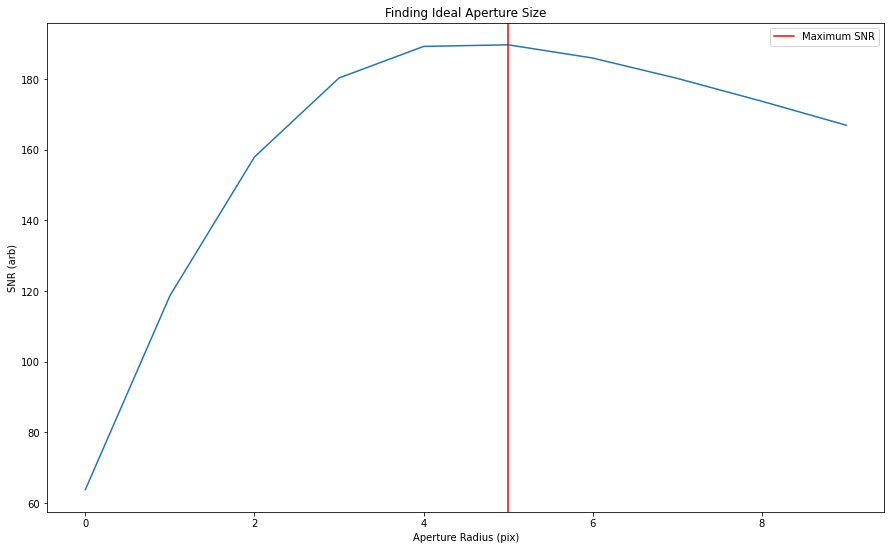

In [10]:
g = findApSize('red_asteroid/reduced_UCD_0'+str(222)+'.fits', p1_coords[0], True, True)
plt.title('Finding Ideal Aperture Size')
plt.xlabel('Aperture Radius (pix)')
plt.ylabel('SNR (arb)')
plt.axvline(x = g, color = 'r', label = 'Maximum SNR')
plt.legend();

# Running these functions for our reference star

In [6]:
refstar1_coords = np.loadtxt('refstar1_coords.txt')
refstar2_coords = np.loadtxt('refstar2_coords.txt')

In [11]:
ref1_FWHM = findFWHM(222, 284, refstar1_coords, 3)
ref2_FWHM = findFWHM(285, 335, refstar2_coords, 4)

In [13]:
np.savetxt('ref1_FWHM.txt', ref1_FWHM)
np.savetxt('ref2_FWHM.txt', ref2_FWHM)

In [14]:
ref1_apsize = [findApSize('red_asteroid/reduced_UCD_0'+str(i+222)+'.fits', refstar1_coords[i], False, True) for i in range(len(refstar1_coords))]
ref2_apsize = [findApSize('red_asteroid/reduced_UCD_0'+str(i+285)+'.fits', refstar2_coords[i], False, True) for i in range(len(refstar2_coords))]

In [15]:
np.savetxt('ref1_apsize.txt', ref1_apsize)
np.savetxt('ref2_apsize.txt', ref2_apsize)